### Imports

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd

import scipy.fft
from ipywidgets import interact
import ipywidgets as widgets

import h5py

import torch # downgraded to 1.10
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.utils.data
import torch.optim as optim
import torchaudio.transforms as T

import scipy.io

from scipy.signal import resample 

from torch.autograd import Variable

#import tensorflow as tf

import matplotlib.pyplot as plt

### Read data and convert to numpy array

In [41]:
import os

In [42]:
def read_simulated_data(file_name, data_dir):
    name = file_name[:-4]
    print('\nname',name)
    
    file = scipy.io.loadmat(os.path.join(data_dir, file_name))
    # Access specific variables or datasets
    data_variable = file['Ia']  
    print('type(data_variable)', type(data_variable))
    print('data_variable.shape',data_variable.shape)
    data_variable = data_variable[0] 
    print('type(data_variable)', type(data_variable))
    print('data_variable.shape',data_variable.shape)

    time_variable = file['Time']
    print('type(time_variable)', type(time_variable))
    print('time_variable.shape',time_variable.shape)
    time_variable = time_variable[0] # divided by 20 - To Numpy Array
    print('type(time_variable)', type(time_variable))
    print('time_variable.shape',time_variable.shape)
    
    return name, data_variable, time_variable

def read_experimental_data(file_name, data_dir):
    name = file_name[:-4]
    print('\nname',name)
    
    with h5py.File(os.path.join(data_dir, file_name), 'r') as file:
        # Access specific variables or datasets
        data_variable = file['ch_AI_6_3']  
        print('type(data_variable)', type(data_variable))
        print('data_variable.shape',data_variable.shape)
        data_variable = data_variable[0]
        print('type(data_variable)', type(data_variable))
        print('data_variable.shape',data_variable.shape)
        
        time_variable = file['ch_AI_6_3_TIME']
        print('type(time_variable)', type(time_variable))
        print('time_variable.shape',time_variable.shape)
        time_variable = time_variable[0] # divided by 20 - To Numpy Array
        print('type(time_variable)', type(time_variable))
        print('time_variable.shape',time_variable.shape)


    return name, data_variable, time_variable

In [43]:
simulated_files = ['100_3BRB_Simu.mat']
experimental_files = ['100_3BRB.mat']
data_dir = 'data'

dataset = {}
for file in simulated_files:
    name, data_variable, time_variable = read_simulated_data(file, data_dir)
    dataset[name] = (data_variable, time_variable)
    
for file in experimental_files:
    name, data_variable, time_variable = read_experimental_data(file, data_dir)
    dataset[name] = (data_variable, time_variable)


name 100_3BRB_Simu
type(data_variable) <class 'numpy.ndarray'>
data_variable.shape (1, 80001)
type(data_variable) <class 'numpy.ndarray'>
data_variable.shape (80001,)
type(time_variable) <class 'numpy.ndarray'>
time_variable.shape (1, 80001)
type(time_variable) <class 'numpy.ndarray'>
time_variable.shape (80001,)

name 100_3BRB
type(data_variable) <class 'h5py._hl.dataset.Dataset'>
data_variable.shape (1, 1217400)
type(data_variable) <class 'numpy.ndarray'>
data_variable.shape (1217400,)
type(time_variable) <class 'h5py._hl.dataset.Dataset'>
time_variable.shape (1, 1217400)
type(time_variable) <class 'numpy.ndarray'>
time_variable.shape (1217400,)


In [44]:
list(dataset.keys())

['100_3BRB_Simu', '100_3BRB']

In [45]:
data_variable, time_variable = dataset['100_3BRB_Simu']

### Obtaining and plotting mel-spectrograms

In [46]:
def get_mel_spectrogram(data, sr=20000, scale=False, two_steps=False):
    if scale:
        data_scaled = (data - data.min()) / (data.max() - data.min()) * 2 - 1
    else:
        data_scaled = data
        
    # Compute the Mel spectrogram 
    if two_steps:
        ft_power_data = np.abs(librosa.stft(data_scaled))**2 
        print('ft_power_data.shape', ft_power_data.shape)
        mel_spec = librosa.feature.melspectrogram(S=ft_power_data, sr=20000, n_mels=80) # n_fft=512*7, hop_length=512,
    else:
        mel_spec = librosa.feature.melspectrogram(y=data_scaled, sr=20000, n_mels=80) # n_fft=512*7, hop_length=512,

    return mel_spec

In [47]:
def plot_mel_spectrogram(S, title='Mel-frequency spectrogram', window=157, convert_to_db=True):
    fig, ax = plt.subplots(figsize=(10,8)) 
    S_cut = S[:,:window]
    if convert_to_db:
        S_dB = librosa.power_to_db(S_cut, ref=np.max) 
    else:
        S_dB = S_cut
    img = librosa.display.specshow(S_dB, x_axis='time', 
                             y_axis='mel', sr=20000, 
                             fmax=8000, ax=ax) 
    fig.colorbar(img, ax=ax, format='%+2.0f dB') 
    ax.set_title(title, fontsize=16)
    plt.show()

def plot_signal(y, title, window=1000):
    plt.plot(y[:window])
    plt.title(title)
    plt.show()
    
def compare_signal(y_true, y_rec, title, window=1000):
    plt.plot(y_true[:window], label='True signal')
    plt.plot(y_rec[:window], label='Reconstructed signal')
    plt.title(title)
    plt.legend()
    plt.show()

In [48]:
scale = False
two_steps = False 

exp_sr = 20000
simu_sr = 20000

mel_specs = {}

for key in dataset.keys():
    print('key', key)
    if 'Simu' in key:
        sr = simu_sr
    else:
        sr = exp_sr
    data_variable = dataset[key][0]
    mel_spec = get_mel_spectrogram(data_variable, sr=sr, scale=scale, two_steps=two_steps)
    print('mel_spec.shape', mel_spec.shape)
    mel_specs[key] = mel_spec

key 100_3BRB_Simu
mel_spec.shape (80, 157)
key 100_3BRB
mel_spec.shape (80, 2378)


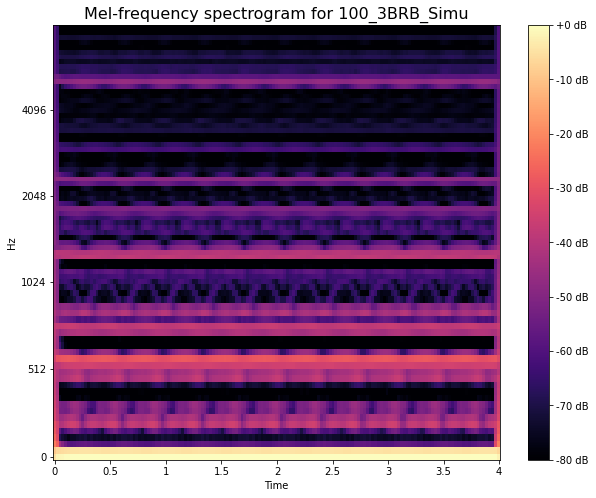

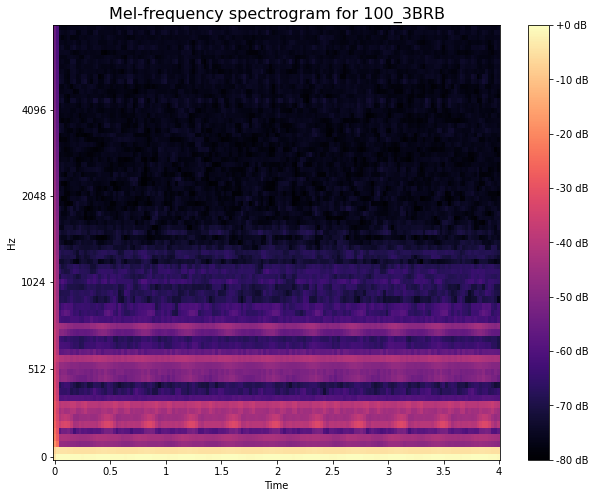

In [49]:
for key in mel_specs.keys():
    plot_mel_spectrogram(mel_specs[key], f'Mel-frequency spectrogram for {key}')

In [50]:
scale = False
two_steps = True # doesn't seem to make a big difference!

exp_sr = 20000
simu_sr = 20000

mel_specs_2steps = {}

for key in dataset.keys():
    print('key', key)
    if 'Simu' in key:
        sr = simu_sr
    else:
        sr = exp_sr
    data_variable = dataset[key][0]
    mel_spec = get_mel_spectrogram(data_variable, sr=sr, scale=scale, two_steps=two_steps)
    mel_specs_2steps[key] = mel_spec

key 100_3BRB_Simu
ft_power_data.shape (1025, 157)
key 100_3BRB
ft_power_data.shape (1025, 2378)


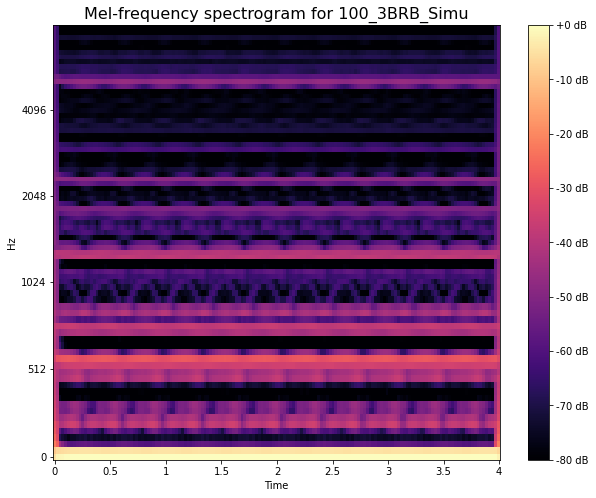

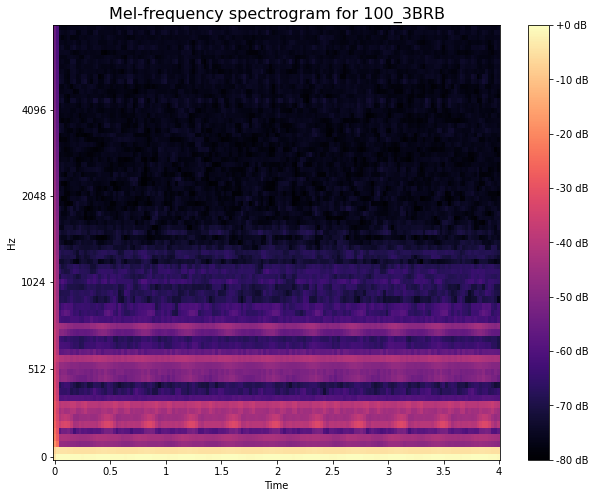

In [51]:
for key in mel_specs_2steps.keys():
    plot_mel_spectrogram(mel_specs_2steps[key], f'Mel-frequency spectrogram for {key}')

### HiFi-GAN demo with one spectrogram in input

Steps:
1. Download dataset with ```wget https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2``` then unzip the file (e.g. with ```tar -xjf https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2```) and move all the files in the LJSpeech-1.1 folder.
2. Create a folder called test_files and copy there some .wav files to test from the LJSpeech-1.1/wav folder, e.g. LJ046-0211.wav
3. From command line run ```python inference.py --checkpoint_file weights/g_02500000```
4. Results are found in the generated_files folder

In [52]:
import pygame # install with pip install pygame

def play_wav(file_path):
    pygame.mixer.init()
    pygame.mixer.music.load(file_path)
    pygame.mixer.music.play()

pygame 2.5.2 (SDL 2.28.2, Python 3.6.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [53]:
file_path = "generated_files/LJ046-0211_generated.wav"
play_wav(file_path)
input("Press Enter to stop playback...")
pygame.mixer.music.stop()

Press Enter to stop playback... 


In [54]:
from meldataset import mel_spectrogram, MAX_WAV_VALUE, load_wav
from env import AttrDict
import json 

with open('weights/config.json') as f:
    _data = f.read()
        
global h
json_config = json.loads(_data)
# this is just a fancy way of passing all the arguments inside config.json to a variable h
h = AttrDict(json_config) 
    
def get_mel(x, h): # this is not the librosa function
    return mel_spectrogram(x, h.n_fft, h.num_mels, h.sampling_rate, h.hop_size, h.win_size, h.fmin, h.fmax)

In [55]:
MAX_WAV_VALUE

32768.0

In [16]:
# Load original and generated and plot them side by side somehow
original_file = "test_files/LJ046-0211.wav"
generated_file = "generated_files/LJ046-0211_generated.wav"

original_wav, original_sr = load_wav(original_file)
generated_wav, generated_sr = load_wav(generated_file)

In [17]:
print('original_wav.shape', original_wav.shape)
print('generated_wav.shape', generated_wav.shape)

original_wav.shape (219549,)
generated_wav.shape (219392,)


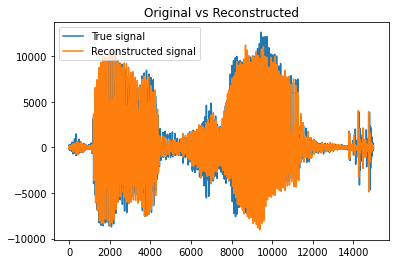

In [18]:
compare_signal(original_wav, generated_wav, title="Original vs Reconstructed", window=15000)

In [19]:
S_original = get_mel(torch.FloatTensor(original_wav).unsqueeze(0), h)[0]
S_reconstructed = get_mel(torch.FloatTensor(generated_wav).unsqueeze(0), h)[0]

min value is  tensor(-12302.)
max value is  tensor(18847.)
min value is  tensor(-17011.)
max value is  tensor(18453.)


/u/94/dainesn1/unix/.conda/envs/hifi-gan/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  """Entry point for launching an IPython kernel.
/l/hifi-gan/meldataset.py:57: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)
/u/94/dainesn1/unix/.conda/envs/hifi-gan/lib/python3.6/site-packages/torch/functional.py:573: UserWarning: stft will soon require the return_

In [20]:
# no idea where the last dimension comes from
print('S_original.shape', S_original.shape)
print('S_reconstructed.shape', S_reconstructed.shape)

S_original.shape torch.Size([80, 857])
S_reconstructed.shape torch.Size([80, 857])


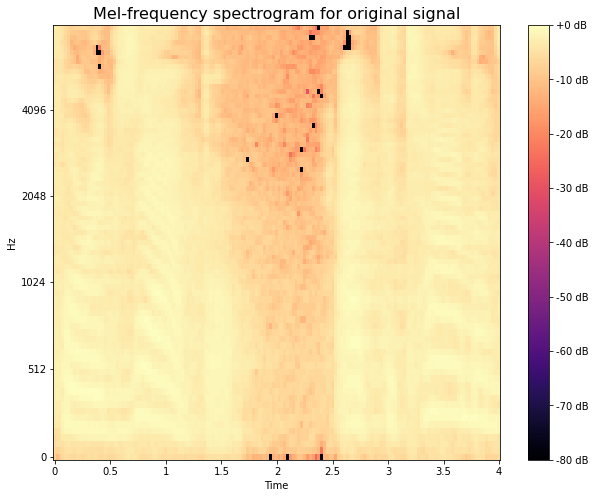

In [21]:
plot_mel_spectrogram(S_original, f'Mel-frequency spectrogram for original signal', convert_to_db=True)

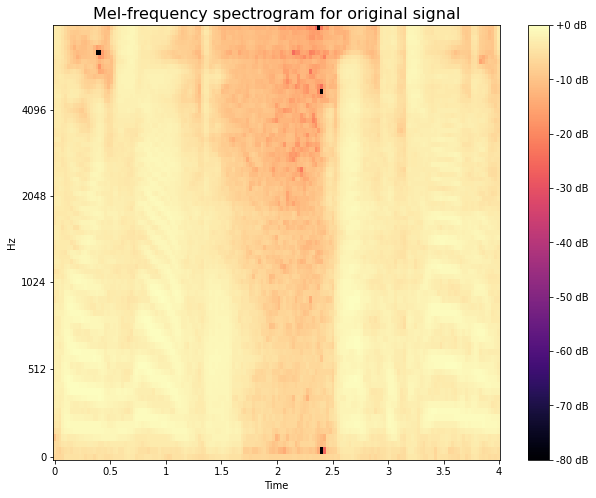

In [22]:
plot_mel_spectrogram(S_reconstructed, f'Mel-frequency spectrogram for original signal', convert_to_db=True)

### Inference with our own spec

In [56]:
def get_mel(x, h=None): # this is not the librosa function
    if h is None:
        return mel_spectrogram(x, 1024, 80, 20000, 256, 1024, 0, 8000)
    else:
        return mel_spectrogram(x, h.n_fft, h.num_mels, h.sampling_rate, h.hop_size, h.win_size, h.fmin, h.fmax)

In [57]:
# Prepare data in input (do re-sampling?)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Use device', device)
samples_per_signal = 219549 # we can change it later, it's just to copy their procedure
exp_name = '100_3BRB'
print("Data from experiment", exp_name)
wav_20k, time_variable = dataset[exp_name] # wav it's our signal, we just follow their naming convention
wav_20k = wav_20k[-samples_per_signal:] # take signal for trial from the end of the experiment

original_sample_rate = 20000  # Sample rate of original signal - 20 kHz 
desired_sample_rate = 22050  # Desired sample rate - 22 kHz 
 
# Resample the signal 
wav = resample(wav_20k, int(len(wav_20k) * (desired_sample_rate / original_sample_rate)))

print('wav.shape', wav.shape)
print('wav.dtype', wav.dtype)
print('wav.max()', wav.max())
print('wav.min()', wav.min())
print('wav.mean()', wav.mean())
WAV_MAX = wav.max()*2
# Normalize signal and cast it to torch Tensor
wav_norm = wav/WAV_MAX
print('wav_norm.max()', wav_norm.max())
print('wav_norm.min()', wav_norm.min())
print('wav_norm.mean()', wav_norm.mean())
wav_norm = torch.FloatTensor(wav_norm).to(device)

# Apply custom mel spectrogram
x = get_mel(wav_norm.unsqueeze(0))
print('x.shape', x.shape)
print('x.max()', x.max())
print('x.min()', x.min())
print('x.mean()', x.mean())

Use device cuda
Data from experiment 100_3BRB
wav.shape (242052,)
wav.dtype float64
wav.max() 22.990101203625304
wav.min() -23.21211787424003
wav.mean() -0.07603355604174902
wav_norm.max() 0.5
wav_norm.min() -0.5048285274746793
wav_norm.mean() -0.001653615079122822
x.shape torch.Size([1, 80, 945])
x.max() tensor(1.5309, device='cuda:0')
x.min() tensor(-8.7377, device='cuda:0')
x.mean() tensor(-6.2574, device='cuda:0')


/l/hifi-gan/meldataset.py:57: FutureWarning: Pass sr=20000, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel = librosa_mel_fn(sampling_rate, n_fft, num_mels, fmin, fmax)


In [58]:
# Load pre-trained model
import json 
from models import Generator

model_dir = 'weights'
generator_file = os.path.join(model_dir,'g_02500000')
with open(os.path.join(model_dir,'config.json')) as f:
    _data = f.read()
        
global h
json_config = json.loads(_data)
h = AttrDict(json_config) 

# Init model
generator = Generator(h).to(device)

# Load checkpoint from file to the model weights
state_dict_g = torch.load(generator_file, map_location=device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval()
generator.remove_weight_norm()

Removing weight norm...


In [59]:
# Do forward pass
with torch.no_grad():
    y_g_hat = generator(x)
    print('y_g_hat.shape', y_g_hat.shape)
    print('y_g_hat.max()', y_g_hat.max())
    print('y_g_hat.min()', y_g_hat.min())
    print('y_g_hat.mean()', y_g_hat.mean())

y_g_hat.shape torch.Size([1, 1, 241920])
y_g_hat.max() tensor(0.3946, device='cuda:0')
y_g_hat.min() tensor(-0.3931, device='cuda:0')
y_g_hat.mean() tensor(0.0046, device='cuda:0')


In [60]:
# Convert file to final format
rec_wav = y_g_hat.squeeze() # remove the batch dim
rec_wav = rec_wav * WAV_MAX # re-scale
rec_wav = rec_wav.detach().cpu().numpy().astype(np.float64())
print('rec_wav.shape', rec_wav.shape)
print('rec_wav.dtype', rec_wav.dtype)

rec_wav.shape (241920,)
rec_wav.dtype float64


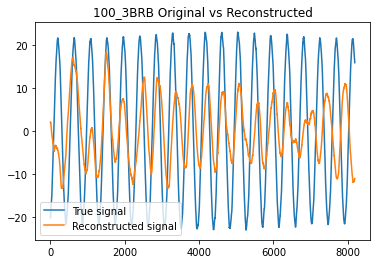

In [62]:
def compare_signal(y_true, y_rec, title, window):
    plt.plot(y_true[:window], label='True signal')
    plt.plot(y_rec[:window], label='Reconstructed signal')
    plt.title(title)
    plt.legend()
    plt.show()
    
compare_signal(wav, rec_wav, title=exp_name+' Original vs Reconstructed')

In [ ]:
# Save to file

### Inverting mel-spectrograms (not needed)

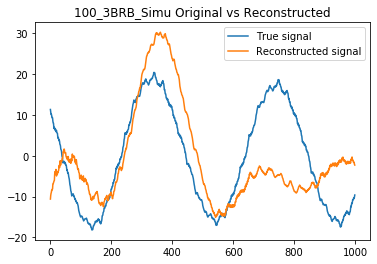

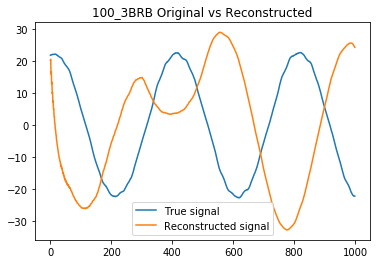

In [85]:
for key in mel_specs_2steps.keys():
    S = librosa.feature.inverse.mel_to_stft(mel_specs_2steps[key]) 
    y_rec = librosa.griffinlim(S)
    compare_signal(data[key][0], y_rec, title=key+' Original vs Reconstructed')

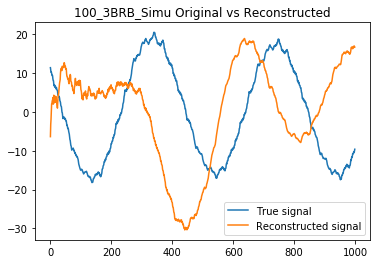

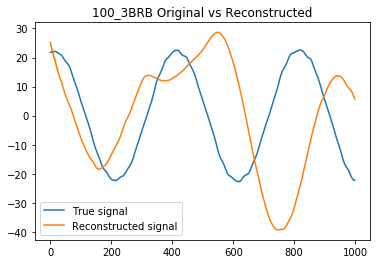

In [86]:
for key in mel_specs.keys():
    S = librosa.feature.inverse.mel_to_stft(mel_specs[key]) 
    y_rec = librosa.griffinlim(S)
    compare_signal(data[key][0], y_rec, title=key+' Original vs Reconstructed')